# **Variational AutoEncoder (VAE)**

<img src="https://drive.google.com/uc?export=download&id=1kwK_AcpiAkZDiAtbR14UvWrBE_5uQ24a" align="center" style="float" width="800">

### **Variational autoencoder**

Versión de F. Chollet.

El autoencoder estándar puede tener un problema debido a que el espacio latente puede ser irregular [1]. Es decir, puntos cercanos en el espacio latente pueden producir salidas muy diferentes, y sin sentido, en el decoder.

Una solución a esto es el Variational Autoencoder. Al igual que el autoencoder se compone de dos redes neuronales, el encoder y el decoder, pero hay varias diferencias:

- El input al decoder se codifica como una **distribución** sobre el espacio latente, en vez de como un único punto. Esta distribución se elige que sea normal (Gaussiana) de tal forma que el encoder da como salida el vector media y la matriz de covarianza. En otras palabras, el encoder toma como entrada un patrón (una imagen por ejemplo), y devuelve un vector media y una matriz de covarianza asociada a ese patrón.

- Para utilizar el decoder, se toma un punto de la distribución dada por el encoder, se aplica el decoder en él, y se calcula el error de reconstrucción.

- Este error se utiliza para calcular el loss del VAE. Since the sampling procedure is a discrete process, so it’s not continuous, we need to apply a reparameterisation trick to make the backpropagation work:

$$
z = E(z) + \epsilon \cdot \sqrt{V(z)}
$$

donde $\epsilon \sim N(0, I)$

### **VAE Loss Function**

El loss del VAE consta de dos términos:

- El **error de reconstrucción**, que se obtiene comparando la entrada al encoder con la salida del decoder.

- El **término de regularización KL**, también llamada "divergencia de Kullback-Leibler" entre la distribución devuelta por el encoder y la distribución normal (distribución Gaussiana) [3]. Este término actúa como un regularizador en el espacio latente, haciendo que las distribuciones devueltas por el encoder sean lo más parecidas posibles a una distribución normal (distribución Gaussiana).

$$
loss = error\_reconstrucción + KL(z, N(0,I))
$$

### **Links de interés**

[1] https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

[2] https://atcold.github.io/pytorch-Deep-Learning/en/week08/08-3/

[3] https://avandekleut.github.io/vae/

**Encoder del VAE**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [2]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 50)                   39250     ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 10)                   510       ['dense[0][0]']               
                                                                                            

**Capa de sampling en el espacio latente**

In [3]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
#  a = log(varianza),  varianza = exp(a), std = sqrt(exp(a)) = exp(0.5*a)
#  epsilon: gaussiana media 0, desviación estándar 1

**Decoder del VAE (mapea puntos del espacio latente a imágenes)**

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10, activation="relu")(latent_inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(28*28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 50)                550       
                                                                 
 dense_4 (Dense)             (None, 784)               39984     
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 40564 (158.45 KB)
Trainable params: 40564 (158.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Modelo VAE con `train_step()` propio**

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**Entrenamiento del VAE**

In [7]:
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 56s 99ms/step - total_loss: 218.2424 - reconstruction_loss: 211.3456 - kl_loss: 6.8975
Epoch 2/30
547/547 [==============================] - 42s 77ms/step - total_loss: 177.2442 - reconstruction_loss: 174.1288 - kl_loss: 3.1154
Epoch 3/30
547/547 [==============================] - 42s 77ms/step - total_loss: 169.1233 - reconstruction_loss: 165.8338 - kl_loss: 3.2895
Epoch 4/30
547/547 [==============================] - 44s 81ms/step - total_loss: 165.5592 - reconstruction_loss: 162.1962 - kl_loss: 3.3632
Epoch 5/30
547/547 [==============================] - 47s 85ms/step - total_loss: 163.4496 - reconstruction_loss: 160.0613 - kl_loss: 3.3882
Epoch 6/30
547/547 [==============================] - 44s 81ms/step - total_loss: 161.7930 - reconstruction_loss: 158.3502 - kl_loss: 3.4427
Epoch 7/30
547/547 [==============================] - 44s 81ms/step - total_loss: 160.4024 - reconstruction_loss: 156.9237 - kl_loss: 3.4787
Epoch 8/30
54

## Espacio latente

In [9]:
salida_encoder = encoder.predict(mnist_digits)

2188/2188 [==============================] - 4s 2ms/step


In [10]:
salida_encoder[0] # medias de las distribuciones

array([[-0.9509185 , -0.16423191],
       [ 0.95597154, -1.4184465 ],
       [ 0.55575794,  0.23676299],
       ...,
       [-0.07962446,  0.8504497 ],
       [-0.9921374 ,  0.4604411 ],
       [ 1.6204339 , -0.05598988]], dtype=float32)

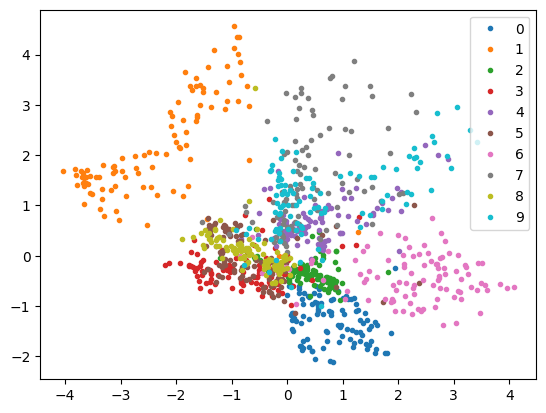

In [12]:
import matplotlib.pyplot as plt
for clase in range(10):
  aux = salida_encoder[0][y==clase][:100]
  plt.plot(aux[:,0], aux[:,1], ".", label=clase)
plt.legend();

**Generación de una rejilla de imágenes a partir del espacio latente 2D**

30it [01:28,  2.94s/it]


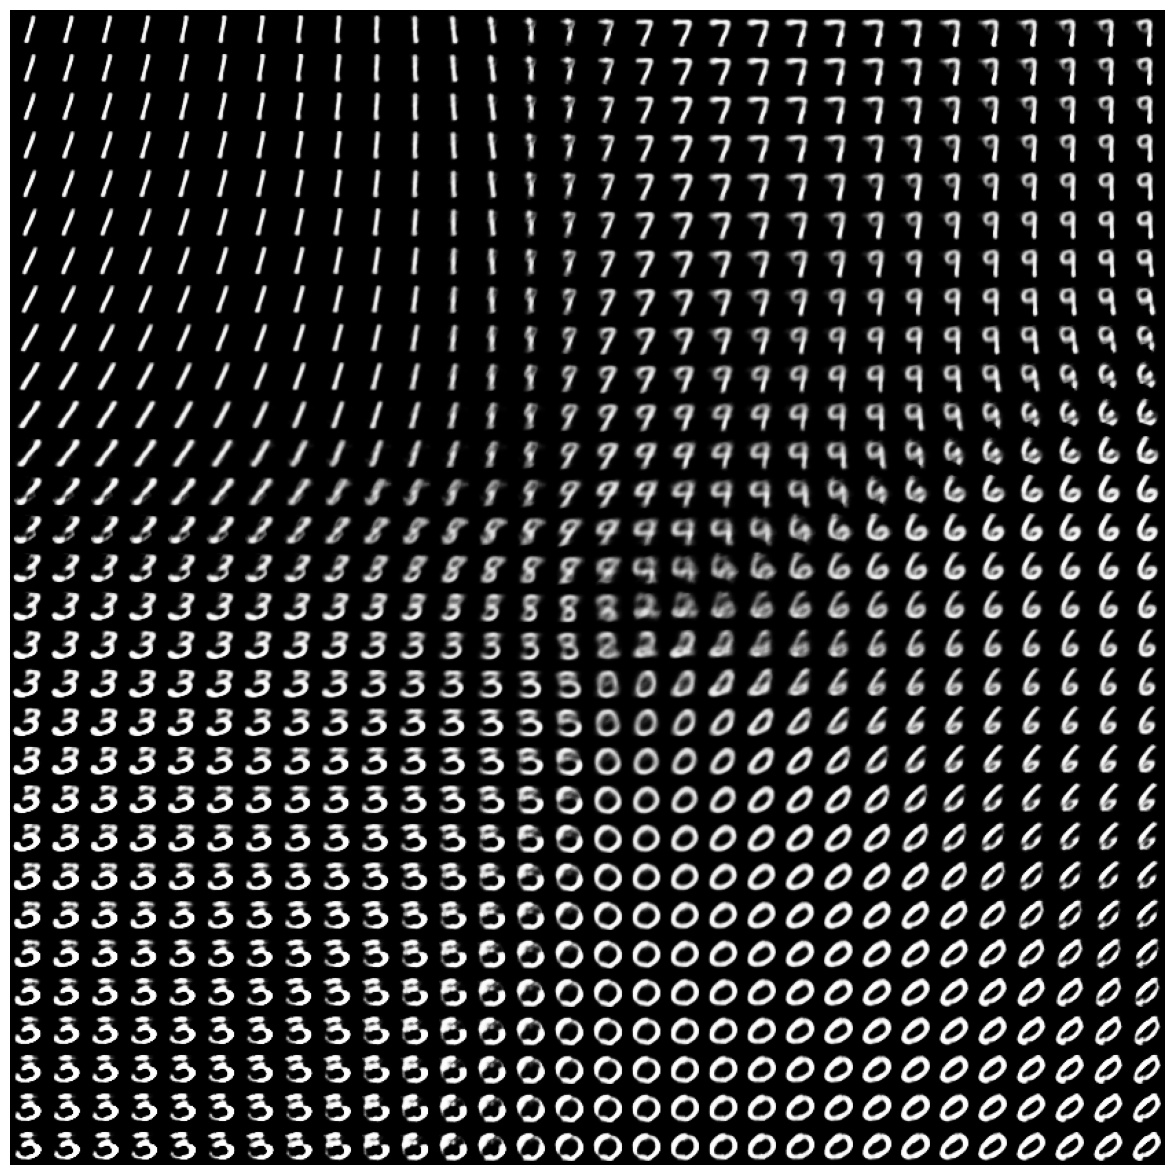

In [14]:
from tqdm import tqdm

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")